# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Автокодировщик { display-mode: "both" }
# В этой программе реализован автокодировщик с помощью двух полносвязных слоев
#@markdown [Оригинальная программа](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
# Считывание данных
mnist = input_data.read_data_sets("sample_data/MNIST_data", one_hot=True)

# Настройка гиперпараметров
learning_rate = 3e-3 #@param {type: "number"}
num_epochs = 20000 #@param {type: "integer"}
batch_size = 32 #@param {type: "integer"}

display_step = 1000

# Настройка параметров сетей
num_hidden_1 = 128
num_hidden_2 = 100
num_sq = int(np.sqrt(num_hidden_2))
num_input = 784

# Xavier Glorot инициализация переменных
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

Extracting sample_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting sample_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
#@markdown - **Создание graph**
with tf.name_scope('Input'):
    X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(glorot_init([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(glorot_init([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(glorot_init([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(glorot_init([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([num_hidden_1])),
    'encoder_b2': tf.Variable(glorot_init([num_hidden_2])),
    'decoder_b1': tf.Variable(glorot_init([num_hidden_1])),
    'decoder_b2': tf.Variable(glorot_init([num_input])),
}

# Кодировщик
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

# Дешифратор
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Структура сети
with tf.name_scope('Net'):
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

with tf.name_scope('Output'):
    y_pred = decoder_op
    y_true = X

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    # # Когда функция активации последнего слоя кодировщика является сигмовидной функцией
    # loss = -tf.reduce_mean(y_true * tf.log(1e-10 + y_pred) + (1 - y_true) * tf.log(1e-10 + 1 - y_pred))
with tf.name_scope('Train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [0]:
#@markdown - **Обучение сетей**
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    start_time = time.time()
    for epoch in range(num_epochs):
        batch_x, _ = mnist.train.next_batch(batch_size)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})

        if (epoch + 1) % display_step == 0:
            end_time = time.time()
            running_time = end_time - start_time
            start_time = end_time
            print_list = [epoch + 1, l, running_time]
            print('Epoch {0[0]}: Minibatch Loss: {0[1]:.4f}, running time: {0[2]:.4f}s.'.format(print_list))

    # Проверить способность сети для кодирования и декодирования изображений
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    img_features = np.empty((n * n, num_sq, num_sq))
    for i in range(n):
        batch_x, _ = mnist.test.next_batch(n)
        f, g = sess.run([encoder_op, decoder_op], feed_dict={X: batch_x})
        for j in range(n):
            img_features[i * n + j] = f[j].reshape([num_sq, num_sq])
        for j in range(n):
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        for j in range(n):
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])
sess.close()

Epoch 1000: Minibatch Loss: 0.0247, running time: 3.7214s.
Epoch 2000: Minibatch Loss: 0.0207, running time: 3.5764s.
Epoch 3000: Minibatch Loss: 0.0158, running time: 3.4640s.
Epoch 4000: Minibatch Loss: 0.0126, running time: 3.5747s.
Epoch 5000: Minibatch Loss: 0.0123, running time: 3.4770s.
Epoch 6000: Minibatch Loss: 0.0098, running time: 3.5500s.
Epoch 7000: Minibatch Loss: 0.0098, running time: 3.5650s.
Epoch 8000: Minibatch Loss: 0.0100, running time: 3.5020s.
Epoch 9000: Minibatch Loss: 0.0092, running time: 3.5673s.
Epoch 10000: Minibatch Loss: 0.0073, running time: 3.4611s.
Epoch 11000: Minibatch Loss: 0.0078, running time: 3.5449s.
Epoch 12000: Minibatch Loss: 0.0070, running time: 3.4687s.
Epoch 13000: Minibatch Loss: 0.0061, running time: 3.5950s.
Epoch 14000: Minibatch Loss: 0.0058, running time: 3.7129s.
Epoch 15000: Minibatch Loss: 0.0072, running time: 3.5201s.
Epoch 16000: Minibatch Loss: 0.0061, running time: 3.5771s.
Epoch 17000: Minibatch Loss: 0.0052, running time

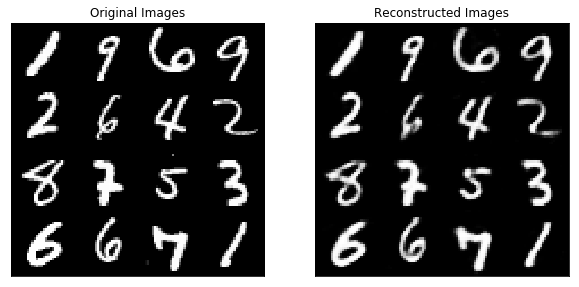

In [0]:
#@markdown - **Сравнение исходных изображений с генерирующими изображениями**
fig = plt.figure(1, figsize=(10, 5))
image_names = ["Original Images", "Reconstructed Images"]
images_o_r = [canvas_orig, canvas_recon]
AX = [fig.add_subplot(i) for i in range(121, 123)]
for na, img, ax in zip(image_names, images_o_r, AX):
    ax.imshow(img, origin="upper", cmap="gray")
    ax.set_title(na)
    ax.set_xticks([]), ax.set_yticks([])
    ax.grid()
plt.show()

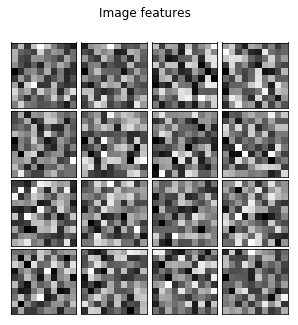

In [0]:
#@markdown - **Представление кодов исходных изображений**
fig_f = plt.figure(2, figsize=(5, 5))
G = gridspec.GridSpec(n, n)
G.wspace, G.hspace = 0.05, 0.05
for i in range(n):
    for j in range(n):
        plt.subplot(G[i, j])
        plt.imshow(img_features[i * n + j], cmap='gray')
        plt.xticks([]), plt.yticks([])
plt.suptitle('Image features')

plt.show()